# 1D predictions for 1 hole


In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\23478671\AppData\Local\Temp\ipykernel_33304\1926853746.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
C:\Users\23478671\AppData\Local\Temp\ipykernel_33304\1926853746.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


- Iteration 0, MSE: 0.262
- Iteration 1000, MSE: 0.022
- Iteration 2000, MSE: 0.020
- Iteration 3000, MSE: 0.019


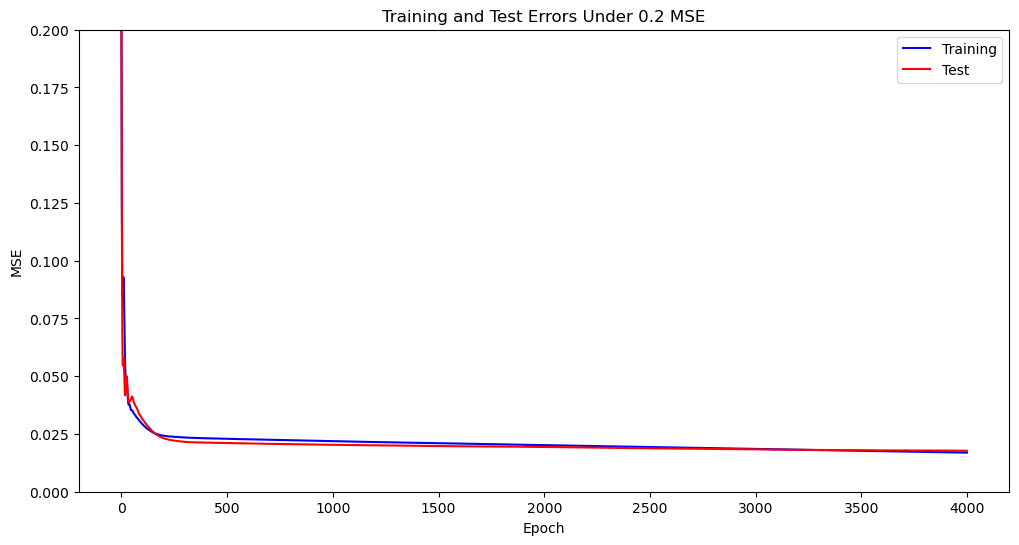

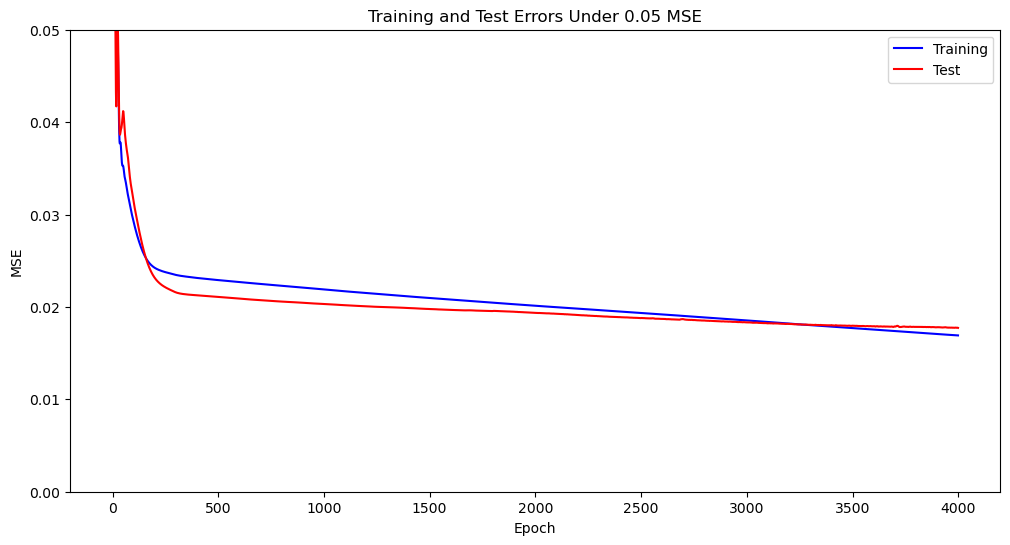

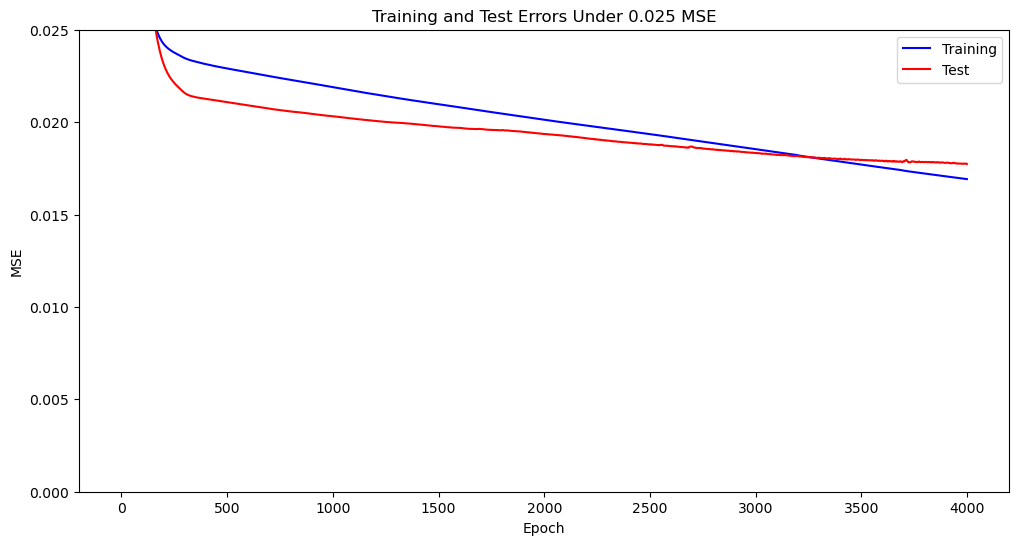

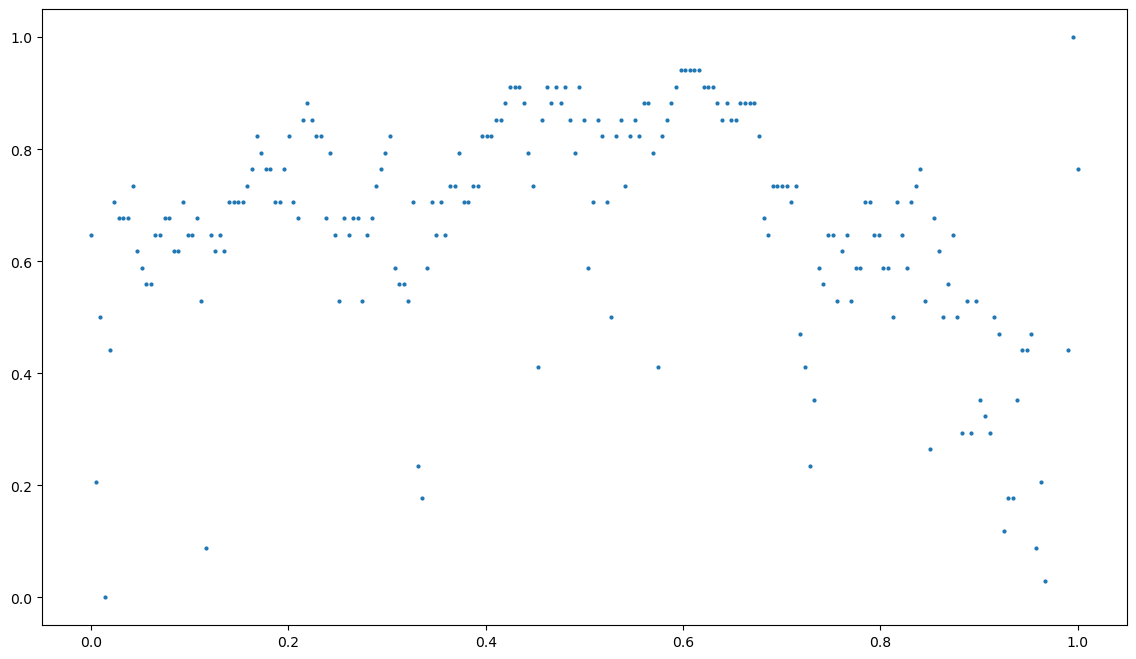

Text(0.5, 1.0, 'Density_gcm3')

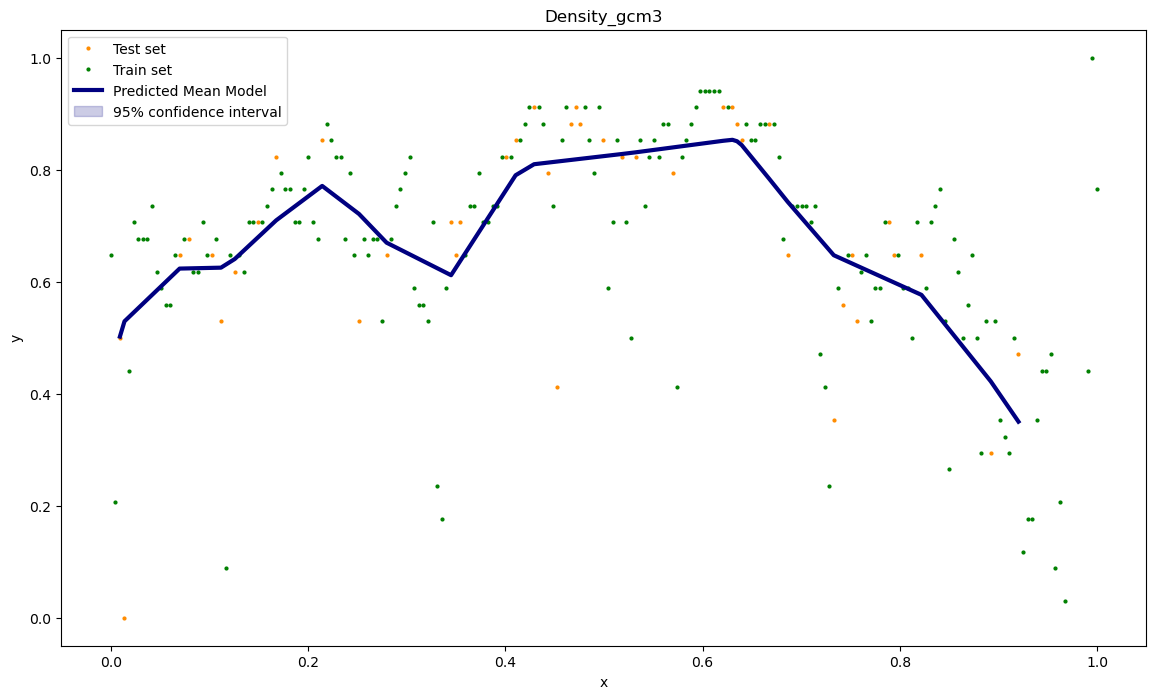

In [3]:



np.random.seed(2147483648)

mineral = 'Density_gcm3'
hole = 'KV-NME001'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])

two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]

# Calculate the mean and standard deviation for the mineral column
mean_value = two_composite_1mineral_1hole[mineral].mean()
std_dev = two_composite_1mineral_1hole[mineral].std()

# Define a threshold for values to be removed (4 standard deviations from the mean)
threshold = 2 * std_dev

# Remove rows where the mineral values are above the threshold
two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1mineral_1hole),3)
x = x[:,2].reshape(-1,1)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]


import matplotlib.pyplot as plt

# Create train and test sets
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    nn.Linear(in_features=1, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(4000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()








models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

models_result = models_result[:, :, 0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



#for x_val in x_test.data.numpy()[:, 0]:
#    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(mineral)

## Now with Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np


from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
hole = 'KV-NME001'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])

two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]

# Calculate the mean and standard deviation for the mineral column
mean_value = two_composite_1mineral_1hole[mineral].mean()
std_dev = two_composite_1mineral_1hole[mineral].std()

# Define a threshold for values to be removed (4 standard deviations from the mean)
threshold = 2 * std_dev

# Remove rows where the mineral values are above the threshold
two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1mineral_1hole),3)
x = x[:,2].reshape(-1,1)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]



n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)








# Define a list of colors for each fold
colors = ['blue', 'green', 'red', 'purple', 'orange']

mse_train_values = []  # To store training MSE for each fold
mse_test_values = []   # To store test MSE for each fold

for i, (train_indices, val_indices) in enumerate(kf.split(x)):
    x_train_fold = x[train_indices]
    y_train_fold = y[train_indices]
    x_val_fold = x[val_indices]
    y_val_fold = y[val_indices]

    model = nn.Sequential(
        nn.Linear(in_features=1, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    for step in range(10000):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Evaluate the model on the training set
        pre_train = model(x_train_fold)
        mse_train = mse_loss(pre_train, y_train_fold)
        train_losses.append(mse_train.item())

        # Evaluate the model on the validation set
        pre_val = model(x_val_fold)
        mse_val = mse_loss(pre_val, y_val_fold)
        test_losses.append(mse_val.item())

    mse_train_values.append(train_losses)
    mse_test_values.append(test_losses)

    print(f'Fold {i + 1}:')
    print(f'Training MSE: {mse_train.item():.2f}, Test MSE: {mse_val.item():.2f}')

# Calculate the mean and standard deviation of training and test MSE values across folds
mean_train_mse = np.mean(mse_train_values, axis=0)
std_train_mse = np.std(mse_train_values, axis=0)
mean_test_mse = np.mean(mse_test_values, axis=0)
std_test_mse = np.std(mse_test_values, axis=0)

print(f'Cross-validation results:')
print(f'Mean Training MSE = {mean_train_mse[-1]:.2f}, Std. Dev. Training MSE = {std_train_mse[-1]:.2f}')
print(f'Mean Test MSE = {mean_test_mse[-1]:.2f}, Std. Dev. Test MSE = {std_test_mse[-1]:.2f}')

# Create a plot of training and test errors for each fold in the same plot
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test Errors Over Epochs for Each Fold')

# Create a plot showing only values lower than 0.03 on the y-axis
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.03)  # Set the y-axis limit to filter values under 0.03
plt.legend()
plt.title('Training and Test Errors Under 0.03 MSE')
plt.show()





models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

models_result = models_result[:, :, 0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



#for x_val in x_test.data.numpy()[:, 0]:
#    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(mineral)





## All Holes

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])
for hole in two_composite_filtered['Name'].unique(): 
    two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]
    if len(two_composite_1mineral_1hole) < 100:
        continue
    
    # Calculate the mean and standard deviation for the mineral column
    mean_value = two_composite_1mineral_1hole[mineral].mean()
    std_dev = two_composite_1mineral_1hole[mineral].std()

    # Define a threshold for values to be removed (4 standard deviations from the mean)
    threshold = 2 * std_dev

    # Remove rows where the mineral values are above the threshold
    two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Fit the scaler to your data and transform the specified columns
    two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



    two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

    x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    x = x.reshape(len(two_composite_1mineral_1hole),3)
    x = x[:,2].reshape(-1,1)

    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(torch.float32)
    y = y.to(torch.float32)

    # Determine the size of the test set (e.g., 20% of the data)
    test_size = int(0.2 * len(x))

    # Generate random indices for the test set
    test_indices = np.random.choice(len(x), size=test_size, replace=False)

    # Create train and test sets based on the indices
    x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
    y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

    x_test = x[np.sort(test_indices)]
    y_test = y[np.sort(test_indices)]

    model = nn.Sequential(
    nn.Linear(in_features=1, out_features=200),  
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=1)
    )

    mse_loss = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for step in range(10000):
        pre = model(x_train)
        mse = mse_loss(pre, y_train)
        cost = mse 
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))
    


    models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

    models_result = models_result[:, :, 0]
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])

    plt.figure(figsize=(14,8))
    plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
    plt.show()

    plt.figure(figsize=(14,8))
    plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
    plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



    plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
    plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



    #for x_val in x_test.data.numpy()[:, 0]:
    #    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(mineral)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# Define your neural network architecture
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=5),  # Replace with standard Linear layer
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)  # Replace with standard Linear layer
)

# Create a dummy input tensor
dummy_input = torch.randn(1, 1)



# Initialize a SummaryWriter for logging
writer = SummaryWriter()

# Log the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the SummaryWriter when finished
writer.close()


In [ ]:

%reload_ext tensorboard
%tensorboard --logdir="C:\Users\23478671\Github\PhD-Thesis---Incorporating-Deep-Learning-into-Statistical-Models-for-Spatial-Interpolation\Paper 3 PhD BNNs for multivariate predictions" --port 5001